In [1]:
!git clone https://github.com/inesdfls/BLAZE

fatal: destination path 'BLAZE' already exists and is not an empty directory.


In [2]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def process_temperature_matrix(thermal_matrix, mask_image, pixels_per_cm=5, distance_cm=1):
    """
    Process a thermal matrix to extract:
    - Maximum temperature (Tmax) in the region of interest
    - Temperatures at a given distance below Tmax (along vertical axis)
    - Mean temperature outside the region of interest (Te)

    Parameters:
        thermal_matrix (np.ndarray): 2D array of temperature values.
        mask_image (np.ndarray): Mask image defining the region of interest.
        pixels_per_cm (int): Number of pixels per centimeter (default is 5).
        distance_cm (int): Distance in cm below Tmax to sample temperatures (default is 1).

    Returns:
        Tmax (float): Maximum temperature in the ROI.
        t_a (list): List of temperatures at specified vertical distances below Tmax.
        t_e (float): Mean temperature outside the ROI.
        distance_cm (int): The input distance in centimeters.
    """

    # Convert mask to grayscale if it's in color
    if mask_image.ndim == 3:
        gray_mask = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    else:
        gray_mask = mask_image.copy()

    # Binarize the mask: 1 for ROI, 0 for the background
    _, binary_mask = cv2.threshold(gray_mask, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply the mask to the thermal matrix
    masked_thermal = thermal_matrix * binary_mask

    # Find the maximum temperature (Tmax) and its location
    Tmax = np.max(masked_thermal)
    max_row, max_col = np.unravel_index(np.argmax(masked_thermal), masked_thermal.shape)

    # Convert distance from cm to pixels
    distance_pixels = int(distance_cm * pixels_per_cm)

    # Sample temperatures along the vertical axis at intervals of 'distance_pixels' below Tmax
    temperatures_at_distance = []
    for i in range(10):
        y = max_row - (i + 1) * distance_pixels
        x = max_col
        if 0 <= y < masked_thermal.shape[0]:
            temperatures_at_distance.append(masked_thermal[y, x])

    # Mean temperature outside the ROI
    Te = np.mean(thermal_matrix[binary_mask == 0])

    return Tmax, temperatures_at_distance, Te, distance_cm

In [4]:
# Traverse the dataset
base_dir = 'BLAZE/data'
results = []

for label in ['healthy', 'sick']:
    label_path = os.path.join(base_dir, label)
    for patient_folder in os.listdir(label_path):
        patient_path = os.path.join(label_path, patient_folder)
        matrices_path = os.path.join(patient_path, 'Matrizes')
        segmentations_path = os.path.join(patient_path, 'Segmentadas')

        # Skip if required folders are missing
        if not os.path.isdir(matrices_path) or not os.path.isdir(segmentations_path):
            continue

        for file_name in os.listdir(matrices_path):
            if file_name.endswith('.txt'):
                try:
                    matrix_file_path = os.path.join(matrices_path, file_name)
                    thermal_matrix = np.loadtxt(matrix_file_path)
                    base_name = file_name.replace('.txt', '')
                    left_mask_path = os.path.join(segmentations_path, f"{base_name}-esq.png")
                    right_mask_path = os.path.join(segmentations_path, f"{base_name}-dir.png")

                    for mask_path in [left_mask_path, right_mask_path]:
                        if os.path.exists(mask_path):
                            # Load the mask as grayscale
                            mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                            Tmax, t_a, t_e, distance_cm = process_temperature_matrix(
                                thermal_matrix, mask_image, pixels_per_cm=5, distance_cm=1
                            )

                            # Append results
                            results.append({
                                'Patient': patient_folder,
                                'File': base_name,
                                'Side': 'left' if 'esq' in mask_path else 'right',
                                'Label': label,
                                'Tmax_C': Tmax,
                                't(a)_C': t_a,
                                't(e)_C': t_e,
                                'a_cm': distance_cm
                            })
                except Exception as e:
                    print(f"Error processing file {file_name}: {e}")

# Convert results to DataFrame
df = pd.DataFrame(results)

Error processing file PAC_36_ESTATICO.txt: could not convert string '31,1' to float64 at row 0, column 1.
Error processing file PAC_35_ESTATICO.txt: could not convert string '31,78' to float64 at row 0, column 1.


In [5]:
# Constants from the Brazilian source code
h0 = 8.77            # W·m⁻²·K⁻¹ — Convective heat transfer coefficient
Ta_blood = 310.15    # K         — Arterial blood temperature ≈ 37°C
qm = 700             # W·m⁻³     — Metabolic heat generation in healthy tissue

# Mathematical Modeling
# Based on equations (17), (18), (20), and (16) from RASTGAR-JAZI & MOHAMMADI (2017)

def eq17_depth_d(Ta, Tmax, Te, a):
    """
    Compute the heat source depth `d` in meters.

    Equation (17): d = a * sqrt((Ta - Te) / (Tmax - Ta))

    Parameters:
        Ta (float): Arterial temperature [K]
        Tmax (float): Maximum surface temperature [K]
        Te (float): Background (non-ROI) temperature [K]
        a (float): Reference distance from the hot spot center [m]

    Returns:
        float: Estimated depth [m]
    """
    return a * np.sqrt((Ta - Te) / (Tmax - Ta))

def eq18_intensity_Q(Ta, Tmax, Te, a, h0=h0):
    """
    Compute thermal power `Q` in watts.

    Equation (18): Q = (4πh₀ (Ta - Te)(Tmax - Te) a²) / (Tmax - Ta)

    Parameters:
        Ta (float): Arterial temperature [K]
        Tmax (float): Maximum surface temperature [K]
        Te (float): Background (non-ROI) temperature [K]
        a (float): Reference distance from the hot spot center [m]
        h0 (float): Convective heat transfer coefficient [W·m⁻²·K⁻¹]

    Returns:
        float: Estimated power output [W]
    """
    return (4 * np.pi * h0 * (Ta - Te) * (Tmax - Te) * a**2) / (Tmax - Ta)

def eq20_radius_R(d, a, Ta_blood=Ta_blood, Te=25, h0=h0, qm=qm):
    """
    Compute the tumor radius `R` in meters.

    Equation (20): R³ = ((Ta_blood - Te)(a² + d²)) / (4πh₀qₘ × 10⁶)

    Parameters:
        d (float): Depth of the heat source [m]
        a (float): Reference distance from the hot spot center [m]
        Ta_blood (float): Arterial blood temperature [K]
        Te (float): Background temperature [K]
        h0 (float): Convective heat transfer coefficient [W·m⁻²·K⁻¹]
        qm (float): Metabolic heat production [W·m⁻³]

    Returns:
        float: Estimated tumor radius [m]
    """
    R_cubed = ((Ta_blood - Te) * (a**2 + d**2)) / (4 * np.pi * h0 * qm * 1e6)
    return np.cbrt(R_cubed)

def eq16_T_profile(a_array, Te, d, R, Q, h0=h0):
    """
    Compute the theoretical temperature profile T(a) at different distances.

    Equation (16): T(a) = Te + Q / (4h₀[(d + R)² + a²])

    Parameters:
        a_array (np.ndarray): Array of distances from the hot spot center [m]
        Te (float): Background temperature [K]
        d (float): Depth of the heat source [m]
        R (float): Radius of the heat source [m]
        Q (float): Heat output [W]
        h0 (float): Convective heat transfer coefficient [W·m⁻²·K⁻¹]

    Returns:
        np.ndarray: Temperature profile [K]
    """
    return Te + Q / (4 * h0 * ((d + R)**2 + a_array**2))

# Temperature Conversion
def C_to_K(Tc):
    """Convert temperature from Celsius to Kelvin."""
    return Tc + 273.15

In [6]:
def generate_thermal_signature(df):
    """
    Generate thermal signatures for each data point in the dataframe.

    For each row in the DataFrame, it estimates the heat source depth (d),
    power (Q), and radius (R) at different vertical distances (a), then
    computes the corresponding theoretical temperature profile.

    Parameters:
        df (pd.DataFrame): DataFrame with the following columns:
            - 't(e)_C': External temperature [°C]
            - 'Tmax_C': Max observed temperature [°C]
            - 't(a)_C': List of temperatures at various distances [°C]
            - 'a_cm': Distance increment between temperature samples [cm]

    Returns:
        pd.DataFrame: Same DataFrame with a new column:
            - 'Thermal_Signature': List of temperature profiles (arrays)
    """
    thermal_signatures = []

    for i in range(len(df)):
        Te_C = df['t(e)_C'][i]
        Tmax_C = df['Tmax_C'][i]
        Ta_C_list = df['t(a)_C'][i]  # List of temperatures at different depths
        a_cm = df['a_cm'][i]

        signature_profiles = []

        # Convert Te and Tmax from Celsius to Kelvin
        Te = C_to_K(Te_C)
        Tmax = C_to_K(Tmax_C)

        for j, Ta_C in enumerate(Ta_C_list):
            try:
                Ta = C_to_K(Ta_C)
                a = a_cm / 100.0 * (j + 1)  # Convert to meters

                # Estimate physical parameters
                d_est = eq17_depth_d(Ta, Tmax, Te, a)
                Q_est = eq18_intensity_Q(Ta, Tmax, Te, a)
                R_est = eq20_radius_R(d_est, a)

                # Compute theoretical temperature profile over ±5 cm
                a_range = np.linspace(-0.05, 0.05, 501)
                T_profile = eq16_T_profile(a_range, Te, d_est, R_est, Q_est)

                signature_profiles.append(T_profile)
            except Exception as e:
                print(f"Error in row {i}, index {j}: {e}")
                signature_profiles.append(np.nan)

        thermal_signatures.append(signature_profiles)

    df['Thermal_Signature'] = thermal_signatures
    return df

In [7]:
generate_thermal_signature(df)

<ipython-input-5-2813067987>:24: RuntimeWarning: invalid value encountered in sqrt
  return a * np.sqrt((Ta - Te) / (Tmax - Ta))


,Patient,File,Side,Label,Tmax_C,t(a)_C,t(e)_C,a_cm,Thermal_Signature
0,66,PAC_16_DN4,left,healthy,33.64,"[32.3, 30.73, 30.32, 30.13, 29.9, 29.7, 29.57,...",26.576218,1,"[[302.9588268022669, 302.98098159364145, 303.0..."
1,66,PAC_16_DN4,right,healthy,33.12,"[31.3, 30.75, 30.57, 30.46, 30.4, 30.39, 30.16...",26.489057,1,"[[301.6284802942586, 301.6429305041918, 301.65..."
2,66,PAC_16_DN12,left,healthy,33.53,"[31.62, 30.6, 30.21, 29.9, 29.76, 29.74, 29.75...",26.592819,1,"[[301.81604730735654, 301.83111251247084, 301...."
3,66,PAC_16_DN12,right,healthy,31.81,"[29.57, 28.11, 27.37, 26.44, 26.18, 25.97, 25....",26.557846,1,"[[300.54935195941465, 300.5557708286018, 300.5..."
4,66,PAC_16_DN7,left,healthy,33.57,"[32.89, 31.25, 30.75, 30.3, 30.16, 30.01, 29.9...",26.602806,1,"[[305.64590746952234, 305.68036024885623, 305...."
...,...,...,...,...,...,...,...,...,...
1497,400,PAC_55_DN4,right,sick,30.87,"[30.05, 29.56, 29.13, 28.85, 28.58, 28.34, 28....",25.000688,1,"[[301.78675347336883, 301.81014472305213, 301...."
1498,400,PAC_55_DN9,right,sick,31.22,"[30.65, 30.34, 29.95, 29.56, 29.33, 29.0, 28.9...",25.098358,1,"[[303.6248767334801, 303.6558576170635, 303.68..."
1499,400,PAC_55_DN7,right,sick,31.31,"[30.84, 30.47, 30.01, 29.49, 29.26, 28.89, 28....",25.190337,1,"[[304.56311767290276, 304.59674310708726, 304...."
1500,400,PAC_55_DN17,right,sick,31.65,"[31.23, 30.79, 30.58, 30.41, 30.38, 30.12, 29....",25.392738,1,"[[305.54265851726296, 305.5786400213282, 305.6..."


In [8]:
# Remove rows where 'Signature_thermique' is a list or array filled entirely with NaNs
df = df[df['Thermal_Signature'].apply(lambda x: isinstance(x, (list, np.ndarray)) and not np.all(np.isnan(x)))]

In [9]:
# Export results to CSV file
df.to_csv('thermal_signatures.csv', index=False)
print("CSV file generated: thermal_signatures.csv")

CSV file generated: thermal_signatures.csv


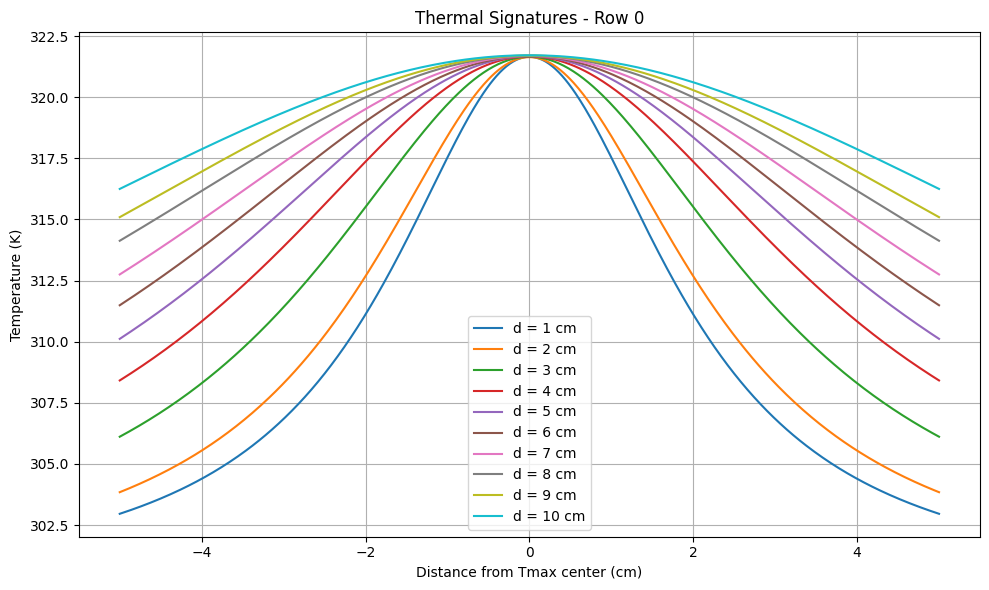

In [10]:
#healthy
row = df.iloc[0]
signatures = row['Thermal_Signature']  # Or 'Signature_thermique' if column not yet renamed

plt.figure(figsize=(10, 6))
a_range = np.linspace(-0.05, 0.05, 501)  # ±5 cm in meters

for i, profile in enumerate(signatures):
    if isinstance(profile, np.ndarray) and not np.all(np.isnan(profile)):
        plt.plot(a_range * 100, profile, label=f'd = {(i+1)*row["a_cm"]} cm')  # convert x-axis to cm

plt.xlabel("Distance from Tmax center (cm)")
plt.ylabel("Temperature (K)")
plt.title("Thermal Signatures - Row 0")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

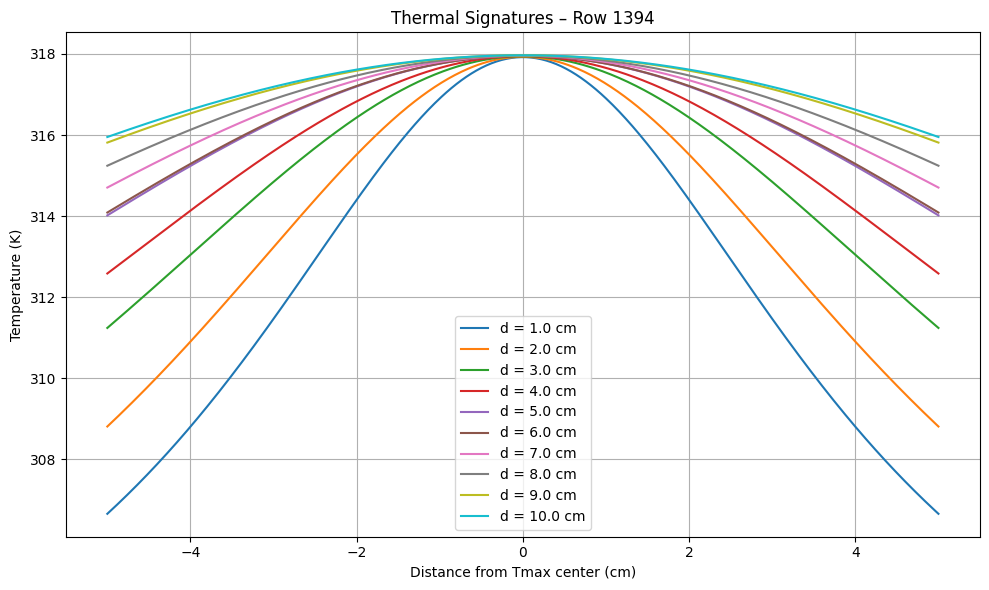

In [11]:
#sick
row_index = 1394
row = df.iloc[row_index]
signatures = row['Thermal_Signature']  # or 'Signature_thermique'

plt.figure(figsize=(10, 6))
a_range = np.linspace(-0.05, 0.05, 501)  # ±5 cm in meters

for i, profile in enumerate(signatures):
    if isinstance(profile, np.ndarray) and not np.all(np.isnan(profile)):
        distance_cm = (i + 1) * row["a_cm"]
        plt.plot(a_range * 100, profile, label=f'd = {distance_cm:.1f} cm')  # x-axis in cm

plt.xlabel("Distance from Tmax center (cm)")
plt.ylabel("Temperature (K)")
plt.title(f"Thermal Signatures – Row {row_index}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
